### # BDI

## LSTM

comme on a vu avec le model VAR, les variables qui 'granger cause' le BDI sont le bsi,le bci,le bpi,le DJI, et le china steel,
donc ces variables qu'on va utiliser aussi ici avec le model LSTM

In [1]:
#to install tensorflow: open anaconda prompt > conda create -n tf tensorflow > conda activate tf
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,SimpleRNN
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
df_bdi=pd.read_csv('Baltic Dry Index Historical Data.csv',parse_dates=['Date'],index_col=['Date'])
df_bsi=pd.read_csv('Baltic Supramax Historical Data.csv',parse_dates=['Date'],index_col=['Date'])
df_bpi=pd.read_csv('Baltic Panamax Historical Data.csv',parse_dates=['Date'],index_col=['Date'])
df_bci=pd.read_csv('Baltic Capesize Historical Data.csv',parse_dates=['Date'],index_col=['Date'])
china_steel=pd.read_csv('STEEL HRC FOB CHINA Futures Historical Data.csv',parse_dates=['Date'],index_col=['Date'])
dow_jones_index=pd.read_csv('Simple-X NY Dow Jones Index ETF (1679).csv',parse_dates=['Date'],index_col=['Date'])

## à l'aide du bsi

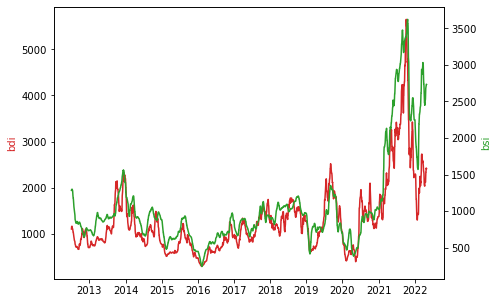

In [3]:
fig, ax1 = plt.subplots(figsize=(7, 5))  
fig = plt.figure(1, figsize=(20, 10)) 
color = 'tab:red'
ax1.set_ylabel('bdi', color = color)  
ax1.plot(df_bdi, color = color)  
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('bsi', color = color)  
ax2.plot(df_bsi, color = color)  
plt.show()

In [4]:
df_bdi_bsi=pd.concat([df_bdi,df_bsi],axis=1)

In [5]:
df_diff=df_bdi_bsi.diff().dropna()

In [6]:
model = VAR(df_diff, freq="1D")
model.select_order(20).summary()

,AIC,BIC,FPE,HQIC
0,12.28,12.28,2.155e+05,12.28
1,10.83,10.84,5.066e+04,10.84
2,10.68,10.70,4.346e+04,10.69
3,10.59,10.61,3.963e+04,10.60
4,10.54,10.58,3.795e+04,10.56
5,10.52,10.55*,3.687e+04,10.53
6,10.51,10.56,3.669e+04,10.53
7,10.51,10.56,3.655e+04,10.52
8,10.50,10.56,3.645e+04,10.52
9,10.50,10.56,3.620e+04,10.52*


#### un jour

In [7]:
def create_dataset_1j(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step:i + time_step+1, 0])
	return np.array(dataX), np.array(dataY)

In [8]:
def creat_model_1j():
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return(model)

In [9]:
train_df=df_diff[:-30].values

In [10]:
time_step = 3
X_train, y_train = create_dataset_1j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

In [11]:
model_1j=creat_model_1j()
model_1j.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             10600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________


In [12]:
hist_1j=model_1j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
56/56 [==============================] - 14s 15ms/step - loss: 1191.2501
Epoch 2/100
56/56 [==============================] - 1s 13ms/step - loss: 1096.3513
Epoch 3/100
56/56 [==============================] - 1s 12ms/step - loss: 1035.4894
Epoch 4/100
56/56 [==============================] - 1s 13ms/step - loss: 988.0240
Epoch 5/100
56/56 [==============================] - 1s 14ms/step - loss: 949.6432
Epoch 6/100
56/56 [==============================] - 1s 13ms/step - loss: 917.3052
Epoch 7/100
56/56 [==============================] - 1s 13ms/step - loss: 890.8482
Epoch 8/100
56/56 [==============================] - 1s 13ms/step - loss: 867.0163
Epoch 9/100
56/56 [==============================] - 1s 14ms/step - loss: 846.4931
Epoch 10/100
56/56 [==============================] - 1s 14ms/step - loss: 828.4434
Epoch 11/100
56/56 [==============================] - 1s 13ms/step - loss: 813.2505
Epoch 12/100
56/56 [==============================] - 1s 14ms/step - loss: 799.43

56/56 [==============================] - 1s 13ms/step - loss: 452.8911
Epoch 99/100
56/56 [==============================] - 1s 12ms/step - loss: 448.1020
Epoch 100/100
56/56 [==============================] - 1s 13ms/step - loss: 450.1443


In [13]:
p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
n_past=3
for i in range(30):
    if p==-1:
        test_df=df_bdi[-1:]
    else:
        test_df=df_bdi[p:p+1]
    test_predict=model_1j.predict(df_diff[p-n_past:p].values.reshape(1,n_past,2))
    x, x_diff = df_bdi['BDI'].iloc[p-1], test_predict.reshape(1,)
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test_df.index)
    values.append(serie[-1:].values.reshape((1,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=1
rmses=rmses/30
maes=maes/30


1/1 [==============================] - 0s 40ms/step


In [14]:
maes,rmses

(22.386966959635416, 22.386966959635416)

In [15]:
values

[array([2337.85791016]),
 array([2358.11669922]),
 array([2306.23046875]),
 array([2300.61938477]),
 array([2240.05444336]),
 array([2132.89428711]),
 array([2108.33007812]),
 array([2048.36450195]),
 array([2055.29931641]),
 array([2041.77404785]),
 array([2021.75488281]),
 array([1984.86938477]),
 array([2057.91333008]),
 array([2102.13867188]),
 array([2219.01147461]),
 array([2106.25537109]),
 array([2121.15600586]),
 array([2123.57348633]),
 array([2125.26293945]),
 array([2115.47509766]),
 array([2170.08862305]),
 array([2332.3269043]),
 array([2308.36547852]),
 array([2339.59472656]),
 array([2361.57519531]),
 array([2409.22998047]),
 array([2429.97412109]),
 array([2437.42431641]),
 array([2359.65429688]),
 array([2394.39453125])]

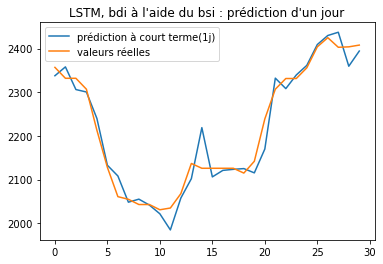

In [16]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df_bdi[-30:].values,label='valeurs réelles')
plt.title("LSTM, bdi à l'aide du bsi : prédiction d'un jour")
plt.legend()

#### un mois

In [16]:
def create_dataset_30j(dataset, n_past=1):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)-29):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        dataY.append(dataset[i :i + 30, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
def creat_model_30j():
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50))
    model.add(Dense(30))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return(model)

In [18]:
train_df=df_diff[:-300].values

In [19]:
time_step = 3
X_train, y_train = create_dataset_30j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_30j=creat_model_30j()
model_30j.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 50)             10600     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
Total params: 32,330
Trainable params: 32,330
Non-trainable params: 0
_________________________________________________________________


In [20]:
hist_30j=model_30j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-300
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_30j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,2)) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], prediction.reshape(30,)
    
    if p==-30:
        test_df=df_bdi[-30:]
    else:
        test_df=df_bdi[p:p+30]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test_df.index)
    values.append(serie[-30:].values.reshape((30,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=30
rmses=rmses/10
maes=maes/10


1/1 [==============================] - 0s 40ms/step


In [21]:
_list_maes

[144.3016357421875,
 464.0255940755208,
 465.9668375651042,
 622.6595377604167,
 349.378125,
 463.91461588541665,
 427.2004150390625,
 451.9257405598958,
 266.272265625,
 106.9446044921875]

In [22]:
maes,rmses
# 5 (461.4537652665007, 385.67256266276036)
#9 (536.1646570220963, 446.9997778320312)
# 20 worst

(376.2589371744792, 460.04315732816383)

In [23]:
values

[array([3232.42871094, 3212.08862305, 3192.76245117, 3177.20874023,
        3164.14526367, 3152.71777344, 3142.04150391, 3131.39794922,
        3119.98413086, 3108.43334961, 3097.08764648, 3088.41845703,
        3079.2722168 , 3070.04760742, 3060.86865234, 3050.82543945,
        3039.2734375 , 3026.53417969, 3012.61206055, 3000.80517578,
        2992.33569336, 2984.64599609, 2975.9453125 , 2966.59350586,
        2958.58618164, 2951.22607422, 2945.83056641, 2942.72192383,
        2942.71044922, 2943.82568359]),
 array([3291.00463867, 3298.13085938, 3304.93164062, 3310.96728516,
        3320.88134766, 3332.08618164, 3341.63305664, 3346.51464844,
        3348.6484375 , 3349.02734375, 3348.73364258, 3351.1184082 ,
        3354.36425781, 3356.14648438, 3355.23046875, 3352.00097656,
        3347.29345703, 3343.04711914, 3342.38452148, 3346.88916016,
        3352.45800781, 3355.73120117, 3356.5222168 , 3356.13110352,
        3354.92626953, 3357.34155273, 3362.20996094, 3367.74169922,
        

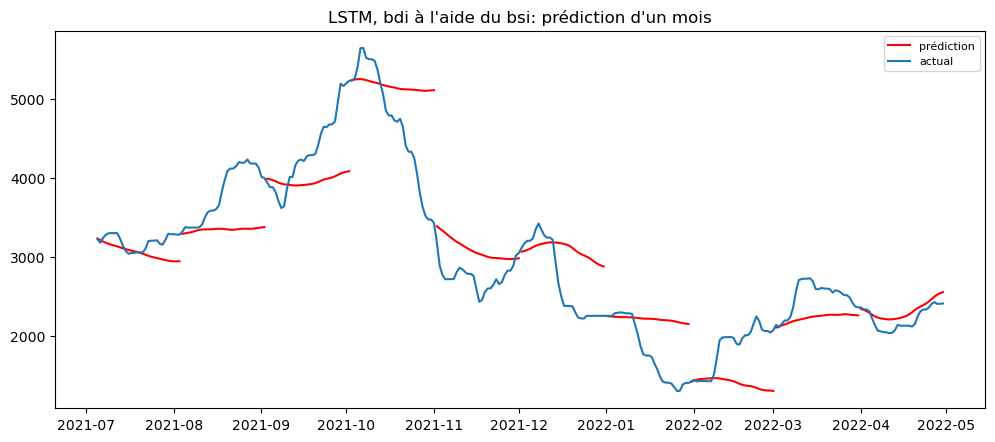

In [24]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-300:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide du bsi: prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

#### une semaine

In [25]:
train_df=df_diff[:-70].values

In [26]:
def create_dataset_7j(dataset, n_past=1):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)-6):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        dataY.append(dataset[i :i + 7, 0])
    return np.array(dataX), np.array(dataY)

In [27]:
def creat_model_7j():
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50))
    model.add(Dense(7))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return(model)

In [28]:
time_step = 3
X_train, y_train = create_dataset_7j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_7j=creat_model_7j()
model_7j.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 50)             10600     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 7)                 357       
                                                                 
Total params: 31,157
Trainable params: 31,157
Non-trainable params: 0
_________________________________________________________________


In [29]:
hist_7j=model_7j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-70
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_7j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,2)) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], prediction.reshape(7,)
    
    if p==-7:
        test_df=df_bdi[-7:]
    else:
        test_df=df_bdi[p:p+7]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test_df.index)
    values.append(serie[-7:].values.reshape((7,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=7
rmses=rmses/10
maes=maes/10


1/1 [==============================] - 0s 38ms/step


In [30]:
maes,rmses

(99.69048549107143, 121.7404529694237)

In [31]:
_list_rmses

[126.52573831924579,
 170.84841227320783,
 289.6311400827702,
 179.95252512573,
 58.971605880165285,
 87.7838025009824,
 45.76250121272971,
 141.18180819135554,
 53.800234655877894,
 62.946761452172474]

In [32]:
_list_maes

[102.51900809151786,
 137.29436383928572,
 236.14181082589286,
 149.91357421875,
 46.657749720982146,
 77.53993443080357,
 40.64491489955357,
 115.45260184151786,
 44.182338169642854,
 46.558558872767854]

In [33]:
values

[array([2016.6706543 , 2021.56604004, 2024.05615234, 2016.82946777,
        2004.5769043 , 1994.95141602, 1990.55761719]),
 array([2044.20153809, 2025.72814941, 2001.3145752 , 1971.17114258,
        1938.60180664, 1911.56799316, 1893.85424805]),
 array([2240.25195312, 2272.34643555, 2286.64282227, 2290.20947266,
        2292.11254883, 2301.10986328, 2317.53100586]),
 array([2730.22094727, 2748.1706543 , 2775.26635742, 2805.36865234,
        2829.05444336, 2840.04150391, 2840.77246094]),
 array([2578.16748047, 2573.38964844, 2578.37963867, 2592.70483398,
        2610.01123047, 2624.56225586, 2632.50341797]),
 array([2480.91723633, 2466.93920898, 2463.41503906, 2464.6574707 ,
        2467.46264648, 2467.42993164, 2462.67089844]),
 array([2288.1159668 , 2253.48486328, 2219.83374023, 2179.16113281,
        2134.83789062, 2093.25952148, 2060.02294922]),
 array([2023.82519531, 2007.00097656, 1987.57873535, 1963.40625   ,
        1940.24389648, 1923.36547852, 1912.41125488]),
 array([2129.374

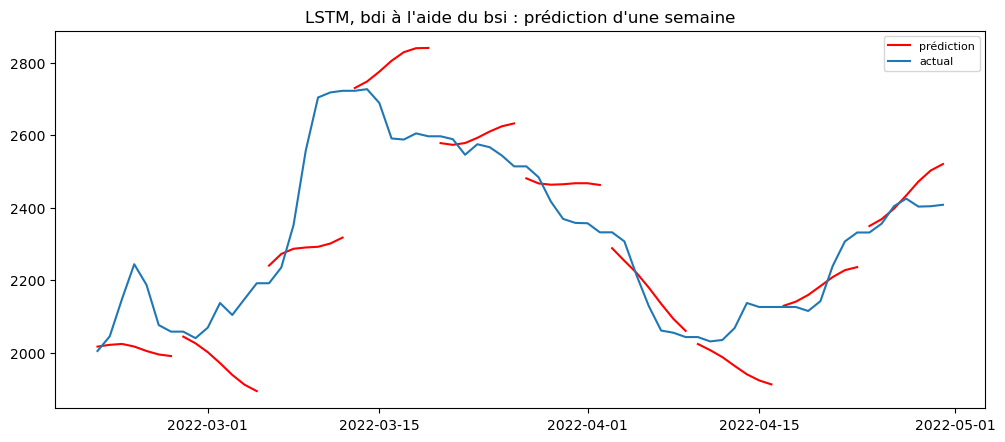

In [34]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-70:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide du bsi : prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

### à l'aide du bci

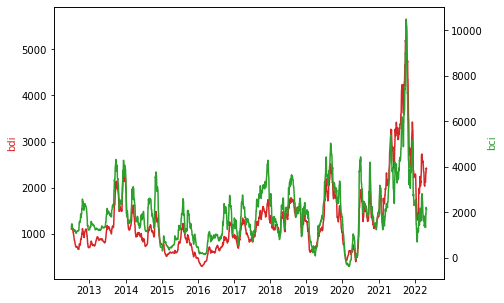

In [35]:
fig, ax1 = plt.subplots(figsize=(7, 5))  
fig = plt.figure(1, figsize=(20, 10)) 
color = 'tab:red'
ax1.set_ylabel('bdi', color = color)  
ax1.plot(df_bdi, color = color)  
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('bci', color = color)  
ax2.plot(df_bci, color = color)  
plt.show()

In [36]:
df_bdi_bci=pd.concat([df_bdi,df_bci],axis=1)

In [37]:
df_diff=df_bdi_bci.diff().dropna()

In [38]:
model = VAR(df_diff, freq="1D")
model.select_order(20).summary()

,AIC,BIC,FPE,HQIC
0,14.41,14.42,1.819e+06,14.42
1,13.42,13.43,6.702e+05,13.42
2,13.36,13.37,6.322e+05,13.36
3,13.31,13.34,6.041e+05,13.32
4,13.30,13.33,5.991e+05,13.31
5,13.29,13.33*,5.931e+05,13.31
6,13.29,13.33,5.908e+05,13.31*
7,13.29,13.34,5.916e+05,13.31
8,13.29,13.35,5.912e+05,13.31
9,13.29,13.35,5.893e+05,13.31


#### un jour

In [39]:
train_df=df_diff[:-30].values

time_step = 3
X_train, y_train = create_dataset_1j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_1j=creat_model_1j()
model_1j.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 3, 50)             10600     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________


In [40]:
hist_1j=model_1j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
n_past=3
for i in range(30):
    if p==-1:
        test_df=df_bdi[-1:]
    else:
        test_df=df_bdi[p:p+1]
    test_predict=model_1j.predict(df_diff[p-n_past:p].values.reshape(1,n_past,2))
    x, x_diff = df_bdi['BDI'].iloc[p-1], test_predict.reshape(1,)
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test_df.index)
    values.append(serie[-1:].values.reshape((1,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=1
rmses=rmses/30
maes=maes/30


1/1 [==============================] - 0s 41ms/step


In [41]:
maes,rmses

(23.917333984375, 23.917333984375)

In [42]:
values

[array([2323.41748047]),
 array([2364.34667969]),
 array([2276.56445312]),
 array([2305.14770508]),
 array([2212.62402344]),
 array([2129.44262695]),
 array([2076.17919922]),
 array([2015.7767334]),
 array([2064.87304688]),
 array([2027.23803711]),
 array([2021.45300293]),
 array([2014.83544922]),
 array([2070.87841797]),
 array([2069.40625]),
 array([2207.02368164]),
 array([2107.6809082]),
 array([2121.28076172]),
 array([2124.45239258]),
 array([2124.05200195]),
 array([2092.28369141]),
 array([2158.84082031]),
 array([2328.39160156]),
 array([2301.50830078]),
 array([2336.49169922]),
 array([2353.36279297]),
 array([2424.54858398]),
 array([2415.24365234]),
 array([2433.18969727]),
 array([2383.79077148]),
 array([2424.01000977])]

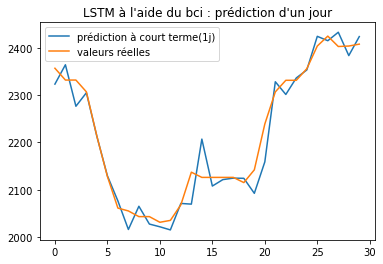

In [43]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df_bdi[-30:].values,label='valeurs réelles')
plt.title("LSTM à l'aide du bci : prédiction d'un jour")
plt.legend()

#### un mois

In [44]:
train_df=df_diff[:-300].values

time_step = 3
X_train, y_train = create_dataset_30j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_30j=creat_model_30j()
model_30j.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 3, 50)             10600     
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 30)                1530      
                                                                 
Total params: 32,330
Trainable params: 32,330
Non-trainable params: 0
_________________________________________________________________


In [45]:
hist_30j=model_30j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-300
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_30j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,2)) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], prediction.reshape(30,)
    
    if p==-30:
        test_df=df_bdi[-30:]
    else:
        test_df=df_bdi[p:p+30]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test_df.index)
    values.append(serie[-30:].values.reshape((30,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=30
rmses=rmses/10
maes=maes/10


1/1 [==============================] - 0s 38ms/step


In [46]:
maes,rmses
#(434.92422973632813, 521.6506780167456)

(400.79476359049477, 482.28623415546247)

In [47]:
values

[array([3221.61645508, 3191.99780273, 3166.14672852, 3143.45068359,
        3123.46313477, 3104.7097168 , 3086.81494141, 3072.05908203,
        3059.38867188, 3048.64941406, 3039.1640625 , 3031.32421875,
        3023.14575195, 3014.72802734, 3006.03662109, 2996.04296875,
        2986.19482422, 2976.90991211, 2967.22070312, 2958.60400391,
        2951.75976562, 2946.85546875, 2942.64404297, 2939.08032227,
        2936.10229492, 2934.04223633, 2932.328125  , 2931.84570312,
        2934.54614258, 2937.51489258]),
 array([3288.53613281, 3294.59326172, 3300.00244141, 3306.02954102,
        3314.00952148, 3324.07788086, 3334.6652832 , 3343.05688477,
        3348.85546875, 3353.61694336, 3357.48339844, 3361.59082031,
        3366.83520508, 3369.97851562, 3371.40722656, 3372.18017578,
        3373.2722168 , 3373.22070312, 3373.45141602, 3374.85522461,
        3377.50537109, 3379.50927734, 3380.69873047, 3382.56542969,
        3383.59887695, 3383.76098633, 3383.56835938, 3383.0144043 ,
        

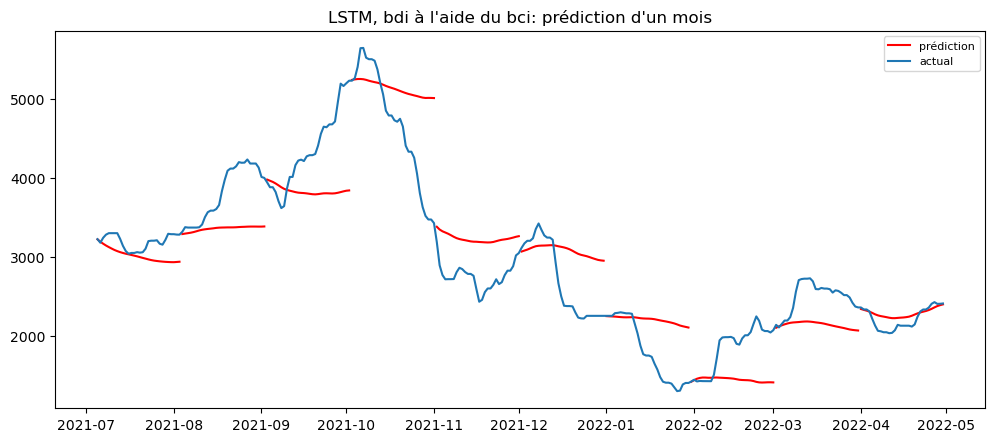

In [48]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-300:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide du bci: prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

#### une semaine

In [49]:
train_df=df_diff[:-70].values

time_step = 3
X_train, y_train = create_dataset_7j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_7j=creat_model_7j()
model_7j.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 3, 50)             10600     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 7)                 357       
                                                                 
Total params: 31,157
Trainable params: 31,157
Non-trainable params: 0
_________________________________________________________________


In [50]:
hist_7j=model_7j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-70
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_7j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,2)) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], prediction.reshape(7,)
    
    if p==-7:
        test_df=df_bdi[-7:]
    else:
        test_df=df_bdi[p:p+7]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test_df.index)
    values.append(serie[-7:].values.reshape((7,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=7
rmses=rmses/10
maes=maes/10


1/1 [==============================] - 0s 38ms/step


In [51]:
maes,rmses

(75.76954520089286, 93.43626272732536)

In [52]:
values

[array([2008.51293945, 2018.98291016, 2041.02856445, 2063.22216797,
        2079.7265625 , 2087.59423828, 2089.24365234]),
 array([2046.48937988, 2034.98876953, 2011.85766602, 1981.8059082 ,
        1954.39196777, 1934.51196289, 1924.71875   ]),
 array([2255.41577148, 2299.99145508, 2335.38208008, 2370.89477539,
        2405.65820312, 2436.63208008, 2461.65917969]),
 array([2703.16918945, 2685.19848633, 2665.05834961, 2633.3293457 ,
        2596.12011719, 2565.33496094, 2544.44775391]),
 array([2575.00634766, 2560.68505859, 2552.43457031, 2544.19970703,
        2534.35473633, 2523.22143555, 2514.21899414]),
 array([2503.23876953, 2497.5324707 , 2487.78027344, 2473.89892578,
        2460.70507812, 2451.00170898, 2445.58789062]),
 array([2290.03149414, 2248.92749023, 2209.01220703, 2167.66918945,
        2128.48217773, 2095.98901367, 2073.72583008]),
 array([2036.55957031, 2022.63574219, 2003.39733887, 1981.92114258,
        1962.26635742, 1948.30627441, 1939.95727539]),
 array([2117.218

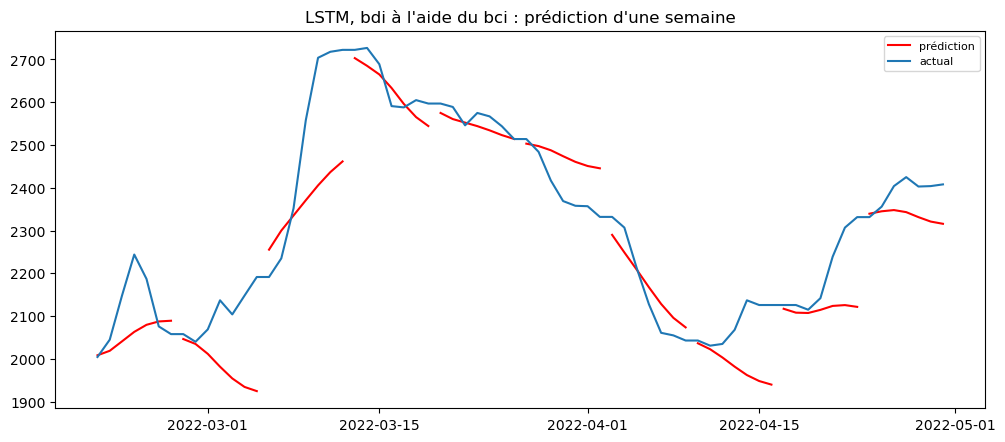

In [53]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-70:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide du bci : prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

### à l'aide du bpi

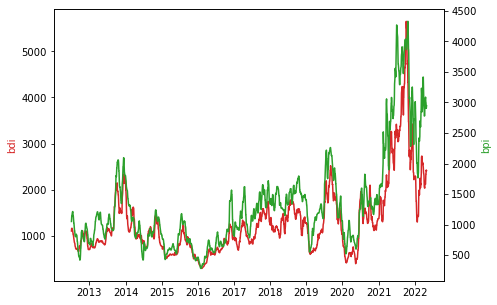

In [54]:
fig, ax1 = plt.subplots(figsize=(7, 5))  
fig = plt.figure(1, figsize=(20, 10)) 
color = 'tab:red'
ax1.set_ylabel('bdi', color = color)  
ax1.plot(df_bdi, color = color)  
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('bpi', color = color)  
ax2.plot(df_bpi, color = color)  
plt.show()

In [55]:
df_bdi_bpi=pd.concat([df_bdi,df_bpi],axis=1)

In [56]:
df_diff=df_bdi_bpi.diff().dropna()

In [57]:
model = VAR(df_diff, freq="1D")
model.select_order(20).summary()

,AIC,BIC,FPE,HQIC
0,13.61,13.61,8.127e+05,13.61
1,12.42,12.43,2.467e+05,12.42
2,12.26,12.28,2.107e+05,12.26
3,12.15,12.17*,1.888e+05,12.16
4,12.15,12.18,1.887e+05,12.16
5,12.15,12.19,1.885e+05,12.16
6,12.14,12.18,1.870e+05,12.15
7,12.14,12.19,1.863e+05,12.15
8,12.14,12.19,1.864e+05,12.16
9,12.13,12.20,1.857e+05,12.16


#### un  jour

In [58]:
train_df=df_diff[:-30].values

time_step = 3
X_train, y_train = create_dataset_1j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_1j=creat_model_1j()
model_1j.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 3, 50)             10600     
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________


In [59]:
hist_1j=model_1j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
n_past=3
for i in range(30):
    if p==-1:
        test_df=df_bdi[-1:]
    else:
        test_df=df_bdi[p:p+1]
    test_predict=model_1j.predict(df_diff[p-n_past:p].values.reshape(1,n_past,2))
    x, x_diff = df_bdi['BDI'].iloc[p-1], test_predict.reshape(1,)
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test_df.index)
    values.append(serie[-1:].values.reshape((1,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=1
rmses=rmses/30
maes=maes/30


1/1 [==============================] - 0s 37ms/step


In [60]:
maes,rmses

(20.934769694010416, 20.934769694010416)

In [61]:
values

[array([2364.93359375]),
 array([2340.53979492]),
 array([2297.6628418]),
 array([2314.82763672]),
 array([2213.91870117]),
 array([2132.56201172]),
 array([2088.03466797]),
 array([2033.0826416]),
 array([2055.86230469]),
 array([2034.16064453]),
 array([2033.40405273]),
 array([1996.77954102]),
 array([2090.49829102]),
 array([2100.13549805]),
 array([2195.91162109]),
 array([2110.78491211]),
 array([2117.42944336]),
 array([2119.83789062]),
 array([2121.86865234]),
 array([2095.12182617]),
 array([2150.98461914]),
 array([2311.64282227]),
 array([2323.67407227]),
 array([2337.12890625]),
 array([2355.27075195]),
 array([2440.33935547]),
 array([2406.8359375]),
 array([2431.2668457]),
 array([2384.98144531]),
 array([2439.04589844])]

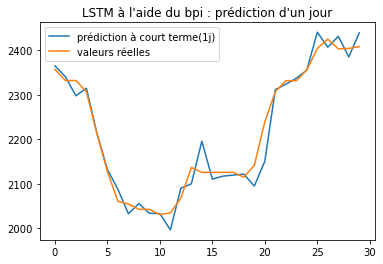

In [62]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df_bdi[-30:].values,label='valeurs réelles')
plt.title("LSTM à l'aide du bpi : prédiction d'un jour")
plt.legend()

#### un mois

In [63]:
train_df=df_diff[:-300].values

time_step = 3
X_train, y_train = create_dataset_30j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_30j=creat_model_30j()
model_30j.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 3, 50)             10600     
                                                                 
 lstm_15 (LSTM)              (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 30)                1530      
                                                                 
Total params: 32,330
Trainable params: 32,330
Non-trainable params: 0
_________________________________________________________________


In [64]:
hist_30j=model_30j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-300
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_30j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,2)) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], prediction.reshape(30,)
    
    if p==-30:
        test_df=df_bdi[-30:]
    else:
        test_df=df_bdi[p:p+30]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test_df.index)
    values.append(serie[-30:].values.reshape((30,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=30
rmses=rmses/10
maes=maes/10


1/1 [==============================] - 0s 37ms/step


In [65]:
maes,rmses

(401.73958699544266, 488.4482337089902)

In [66]:
values

[array([3227.17236328, 3202.09716797, 3174.23461914, 3141.63330078,
        3105.52392578, 3071.1706543 , 3042.80541992, 3020.83740234,
        3001.42358398, 2981.92895508, 2962.78710938, 2944.39428711,
        2926.74291992, 2911.23657227, 2898.59643555, 2885.80957031,
        2872.68188477, 2861.45385742, 2852.21118164, 2844.7902832 ,
        2841.33081055, 2840.0871582 , 2838.5534668 , 2837.61669922,
        2836.99462891, 2837.62402344, 2840.23388672, 2845.24707031,
        2852.68017578, 2860.02075195]),
 array([3297.89599609, 3306.06469727, 3312.08227539, 3319.96582031,
        3332.19335938, 3346.47290039, 3358.45898438, 3365.75756836,
        3371.05200195, 3375.28710938, 3379.54858398, 3384.15478516,
        3388.88134766, 3392.05883789, 3393.16625977, 3393.71142578,
        3394.00195312, 3392.85595703, 3391.79833984, 3389.63183594,
        3385.72485352, 3381.32885742, 3377.42016602, 3374.28491211,
        3371.04833984, 3367.13964844, 3362.36303711, 3356.97802734,
        

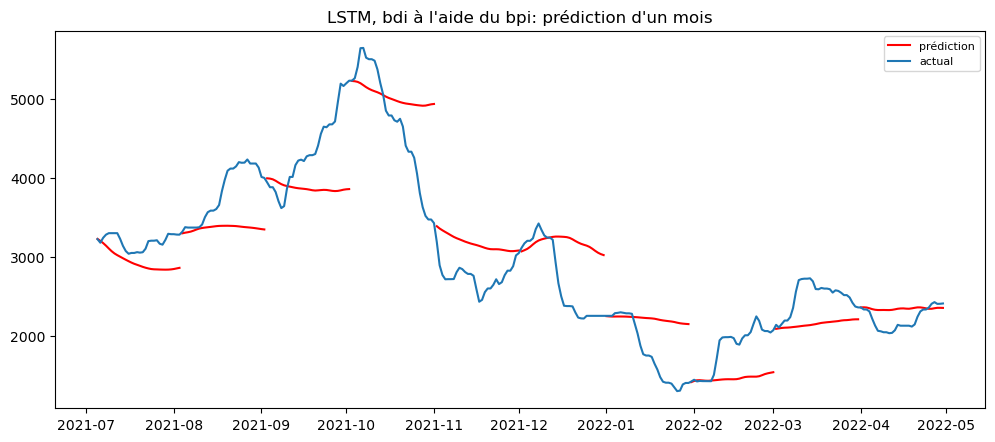

In [67]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-300:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide du bpi: prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

#### semaine

In [68]:
train_df=df_diff[:-70].values

time_step = 3
X_train, y_train = create_dataset_7j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_7j=creat_model_7j()
model_7j.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 3, 50)             10600     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 7)                 357       
                                                                 
Total params: 31,157
Trainable params: 31,157
Non-trainable params: 0
_________________________________________________________________


In [69]:
hist_7j=model_7j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-70
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_7j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,2)) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], prediction.reshape(7,)
    
    if p==-7:
        test_df=df_bdi[-7:]
    else:
        test_df=df_bdi[p:p+7]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test_df.index)
    values.append(serie[-7:].values.reshape((7,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=7
rmses=rmses/10
maes=maes/10


1/1 [==============================] - 0s 39ms/step


In [70]:
maes,rmses

(96.83236083984376, 116.02892458331257)

In [71]:
values

[array([1990.89575195, 1978.44726562, 1969.72473145, 1962.34545898,
        1952.06677246, 1936.30041504, 1919.08312988]),
 array([2046.27966309, 2036.77954102, 2018.74938965, 1991.11230469,
        1962.02319336, 1939.96643066, 1928.29199219]),
 array([2241.83764648, 2274.04199219, 2301.35571289, 2332.19848633,
        2369.55517578, 2406.91503906, 2437.59350586]),
 array([2716.08886719, 2712.44799805, 2702.54980469, 2680.71728516,
        2648.140625  , 2613.21948242, 2588.61523438]),
 array([2564.07495117, 2539.89794922, 2519.72241211, 2501.12011719,
        2484.04223633, 2467.3515625 , 2452.61523438]),
 array([2449.59033203, 2399.51928711, 2356.76831055, 2311.73901367,
        2260.65771484, 2208.03637695, 2163.69238281]),
 array([2286.75756836, 2247.9921875 , 2206.19775391, 2153.73413086,
        2093.85107422, 2038.83581543, 1999.30761719]),
 array([2032.9152832 , 2014.8548584 , 1996.00598145, 1980.5715332 ,
        1970.20288086, 1965.45153809, 1964.08642578]),
 array([2120.376

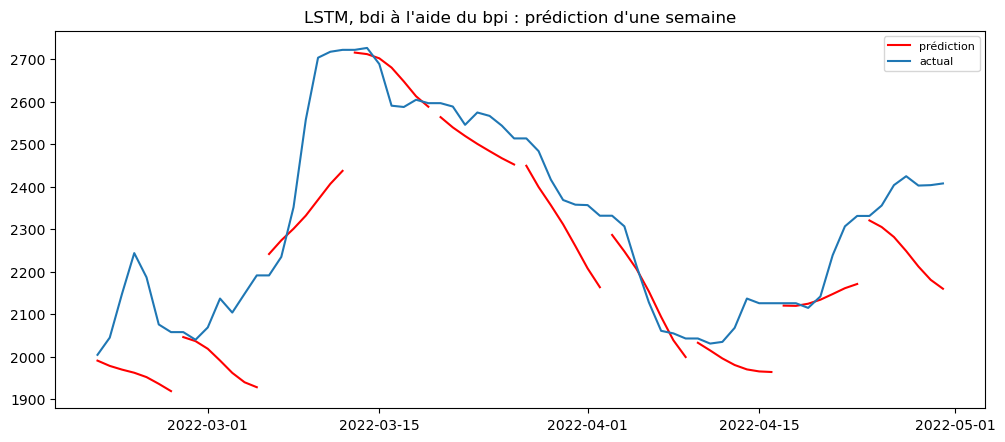

In [72]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-70:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide du bpi : prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

### à l'aide du china steel

In [73]:
df_bdi_china_steel=pd.concat([df_bdi,china_steel],axis=1).dropna()

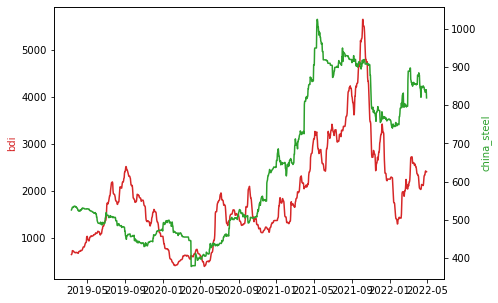

In [74]:
fig, ax1 = plt.subplots(figsize=(7, 5))  
fig = plt.figure(1, figsize=(20, 10)) 
color = 'tab:red'
ax1.set_ylabel('bdi', color = color)  
ax1.plot(df_bdi_china_steel.BDI, color = color)  
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('china_steel', color = color)  
ax2.plot(china_steel, color = color)  
plt.show()

In [75]:
df_diff=df_bdi_china_steel.diff().dropna()

model = VAR(df_diff, freq="1D")
model.select_order(20).summary()

,AIC,BIC,FPE,HQIC
0,11.92,11.93,1.510e+05,11.93
1,11.44,11.47,9.312e+04,11.45
2,11.40,11.44,8.894e+04,11.41
3,11.36,11.42*,8.556e+04,11.38*
4,11.36,11.44,8.587e+04,11.39
5,11.36,11.46,8.565e+04,11.40
6,11.35,11.47,8.523e+04,11.40
7,11.36,11.49,8.548e+04,11.41
8,11.36,11.51,8.574e+04,11.42
9,11.36,11.53,8.553e+04,11.42


#### jour

In [76]:
train_df=df_diff[:-30].values

time_step = 3
X_train, y_train = create_dataset_1j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_1j=creat_model_1j()
model_1j.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 3, 50)             10600     
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________


In [77]:
hist_1j=model_1j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
n_past=3
for i in range(30):
    if p==-1:
        test_df=df_bdi[-1:]
    else:
        test_df=df_bdi[p:p+1]
    test_predict=model_1j.predict(df_diff[p-n_past:p].values.reshape(1,n_past,2))
    x, x_diff = df_bdi['BDI'].iloc[p-1], test_predict.reshape(1,)
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test_df.index)
    values.append(serie[-1:].values.reshape((1,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=1
rmses=rmses/30
maes=maes/30


1/1 [==============================] - 0s 38ms/step


In [78]:
maes,rmses

(22.638944498697917, 22.638944498697917)

In [79]:
values

[array([2357.74072266]),
 array([2355.52124023]),
 array([2272.92529297]),
 array([2299.4519043]),
 array([2244.07470703]),
 array([2152.37573242]),
 array([2095.01293945]),
 array([2024.03503418]),
 array([2040.8494873]),
 array([2025.88269043]),
 array([2014.07055664]),
 array([1967.34338379]),
 array([2036.25476074]),
 array([2104.6237793]),
 array([2174.24243164]),
 array([2111.36450195]),
 array([2123.57202148]),
 array([2121.26049805]),
 array([2131.81884766]),
 array([2093.06201172]),
 array([2167.17895508]),
 array([2297.5793457]),
 array([2313.47851562]),
 array([2341.44067383]),
 array([2354.51489258]),
 array([2416.24511719]),
 array([2424.83398438]),
 array([2430.72924805]),
 array([2409.16040039]),
 array([2416.08789062])]

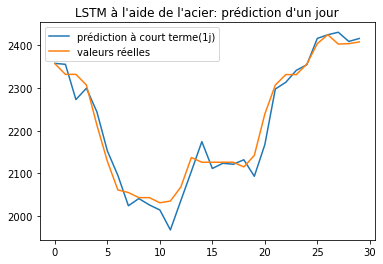

In [80]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df_bdi[-30:].values,label='valeurs réelles')
plt.title("LSTM à l'aide de l'acier: prédiction d'un jour")
plt.legend()

#### mois

In [81]:
train_df=df_diff[:-300].values

time_step = 3
X_train, y_train = create_dataset_30j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_30j=creat_model_30j()
model_30j.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 3, 50)             10600     
                                                                 
 lstm_21 (LSTM)              (None, 50)                20200     
                                                                 
 dense_10 (Dense)            (None, 30)                1530      
                                                                 
Total params: 32,330
Trainable params: 32,330
Non-trainable params: 0
_________________________________________________________________


In [82]:
hist_30j=model_30j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

p=-300
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_30j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,2)) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], prediction.reshape(30,)
    
    if p==-30:
        test_df=df_bdi[-30:]
    else:
        test_df=df_bdi[p:p+30]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test_df.index)
    values.append(serie[-30:].values.reshape((30,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=30
rmses=rmses/10
maes=maes/10


Epoch 1/100
13/13 [==============================] - 8s 16ms/step - loss: 1662.7993
Epoch 2/100
13/13 [==============================] - 0s 16ms/step - loss: 1661.4575
Epoch 3/100
13/13 [==============================] - 0s 14ms/step - loss: 1659.5645
Epoch 4/100
13/13 [==============================] - 0s 14ms/step - loss: 1656.5017
Epoch 5/100
13/13 [==============================] - 0s 13ms/step - loss: 1652.3892
Epoch 6/100
13/13 [==============================] - 0s 13ms/step - loss: 1647.7231
Epoch 7/100
13/13 [==============================] - 0s 15ms/step - loss: 1643.4923
Epoch 8/100
13/13 [==============================] - 0s 14ms/step - loss: 1639.4552
Epoch 9/100
13/13 [==============================] - 0s 14ms/step - loss: 1635.8547
Epoch 10/100
13/13 [==============================] - 0s 13ms/step - loss: 1632.9456
Epoch 11/100
13/13 [==============================] - 0s 14ms/step - loss: 1630.2097
Epoch 12/100
13/13 [==============================] - 0s 13ms/step - loss:

In [83]:
maes,rmses

(430.826767578125, 513.7445567441007)

In [84]:
values

[array([3233.2109375 , 3215.77050781, 3199.85424805, 3184.6640625 ,
        3170.31420898, 3158.04003906, 3147.36328125, 3137.08251953,
        3127.56469727, 3118.29370117, 3109.90771484, 3103.02075195,
        3098.18798828, 3092.109375  , 3085.42626953, 3078.77416992,
        3073.21191406, 3070.0559082 , 3070.49023438, 3072.00097656,
        3075.7175293 , 3079.19580078, 3082.17382812, 3083.9375    ,
        3085.59375   , 3088.52636719, 3092.60668945, 3097.63793945,
        3103.13842773, 3107.125     ]),
 array([3287.65063477, 3293.95117188, 3300.16235352, 3306.62353516,
        3313.20141602, 3320.65136719, 3328.47314453, 3336.34057617,
        3342.74267578, 3348.62084961, 3354.18139648, 3359.90649414,
        3365.93725586, 3372.78808594, 3381.42358398, 3389.68798828,
        3398.4128418 , 3403.44873047, 3404.89746094, 3406.18945312,
        3406.38989258, 3408.10668945, 3410.12353516, 3413.3503418 ,
        3416.74536133, 3418.34155273, 3418.33984375, 3417.81005859,
        

In [85]:
_list_maes

[97.60809733072917,
 437.2328857421875,
 487.1186116536458,
 756.3127766927083,
 810.5474690755208,
 470.83802897135416,
 408.0505126953125,
 407.3898518880208,
 313.55604654947916,
 119.61339518229167]

In [86]:
_list_rmses

[114.83569371260961,
 530.7971382096011,
 607.8654629466249,
 984.4506947191151,
 834.1639875425345,
 563.274235995394,
 512.0800242256535,
 489.18342235771036,
 364.2422431715926,
 136.55266456017134]

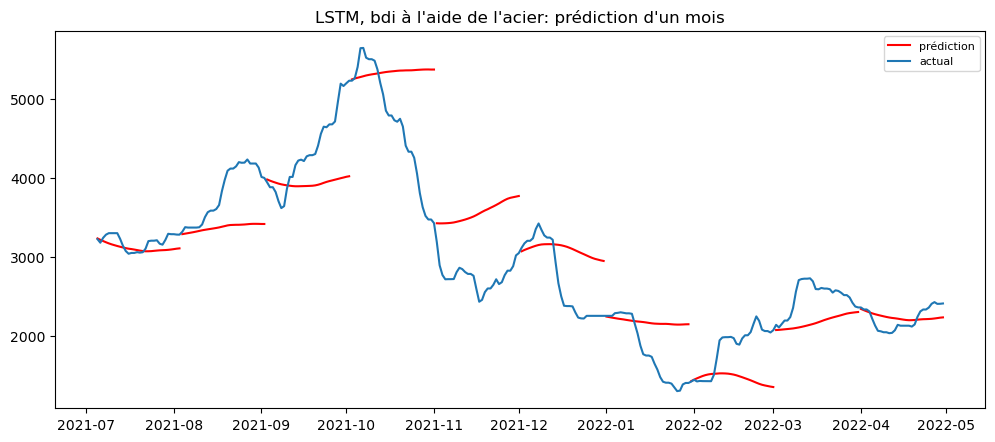

In [87]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-300:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide de l'acier: prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

#### semaine

In [88]:
train_df=df_diff[:-70].values

time_step = 3
X_train, y_train = create_dataset_7j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_7j=creat_model_7j()
model_7j.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 3, 50)             10600     
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dense_11 (Dense)            (None, 7)                 357       
                                                                 
Total params: 31,157
Trainable params: 31,157
Non-trainable params: 0
_________________________________________________________________


In [89]:
hist_7j=model_7j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-70
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_7j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,2)) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], prediction.reshape(7,)
    
    if p==-7:
        test_df=df_bdi[-7:]
    else:
        test_df=df_bdi[p:p+7]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test_df.index)
    values.append(serie[-7:].values.reshape((7,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=7
rmses=rmses/10
maes=maes/10


1/1 [==============================] - 0s 39ms/step


In [90]:
maes,rmses

(118.55960518973215, 143.61014802713808)

In [91]:
_list_maes

[74.18858119419643,
 157.986572265625,
 250.61666434151786,
 50.191964285714285,
 19.651890345982142,
 92.94489397321429,
 149.05416434151786,
 171.11390904017858,
 153.34190150669642,
 66.50551060267857]

In [92]:
_list_rmses

[93.51765278890514,
 184.72504379941827,
 312.5365630381717,
 60.412771348562885,
 27.18935027270346,
 108.6580110850996,
 182.45438702785196,
 196.86854856027225,
 194.02489318146888,
 75.71425916892676]

In [93]:
values

[array([2048.20629883, 2084.15087891, 2117.41430664, 2150.45068359,
        2182.05322266, 2209.40722656, 2231.97387695]),
 array([2024.79980469, 1996.61669922, 1970.16491699, 1944.26831055,
        1920.24780273, 1900.4967041 , 1884.99975586]),
 array([2213.69140625, 2230.88012695, 2245.10498047, 2258.02783203,
        2268.26879883, 2275.32885742, 2279.76416016]),
 array([2710.58886719, 2701.45849609, 2693.17602539, 2685.20141602,
        2675.70117188, 2667.71923828, 2662.09326172]),
 array([2588.72460938, 2581.6953125 , 2576.12231445, 2572.5847168 ,
        2571.05444336, 2571.2434082 , 2572.14770508]),
 array([2506.14331055, 2499.39086914, 2494.40087891, 2492.25170898,
        2490.67602539, 2491.10913086, 2491.92895508]),
 array([2321.26000977, 2311.22436523, 2304.52392578, 2302.63916016,
        2303.33764648, 2306.71948242, 2311.19458008]),
 array([2002.31530762, 1966.27148438, 1933.51501465, 1903.38134766,
        1875.86083984, 1852.67626953, 1834.18237305]),
 array([2101.852

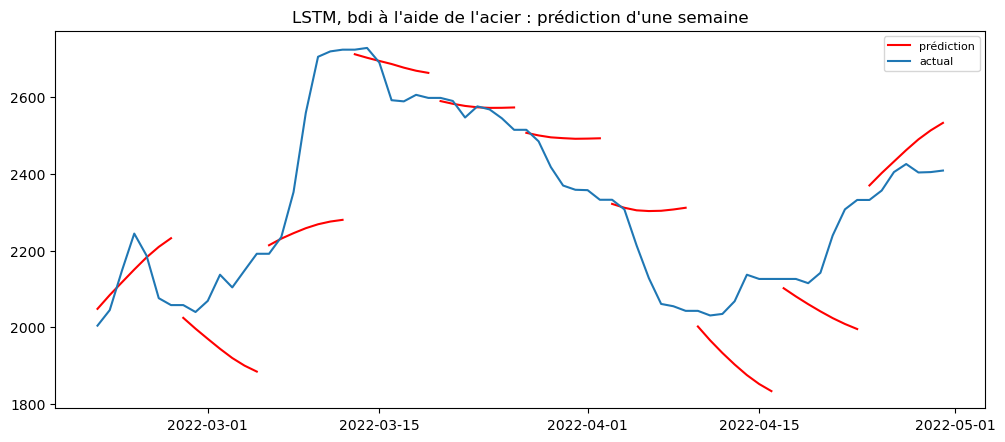

In [94]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-70:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide de l'acier : prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

### à l'aide du dow jones index

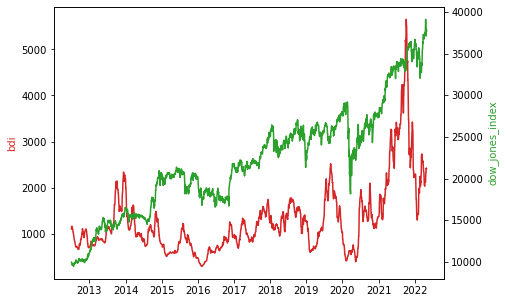

In [95]:
fig, ax1 = plt.subplots(figsize=(7, 5))  
fig = plt.figure(1, figsize=(20, 10)) 
color = 'tab:red'
ax1.set_ylabel('bdi', color = color)  
ax1.plot(df_bdi, color = color)  
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('dow_jones_index', color = color)  
ax2.plot(dow_jones_index, color = color)  
plt.show()

In [96]:
df_bdi_dow_jones_index=pd.concat([df_bdi,dow_jones_index],axis=1).dropna()

In [97]:
df_diff=df_bdi_dow_jones_index.diff().dropna()

model = VAR(df_diff, freq="1D")
model.select_order(20).summary()

,AIC,BIC,FPE,HQIC
0,17.96,17.97,6.319e+07,17.96
1,17.48,17.49,3.915e+07,17.49
2,17.44,17.46,3.750e+07,17.45
3,17.40,17.43*,3.618e+07,17.41
4,17.40,17.44,3.619e+07,17.42
5,17.40,17.44,3.602e+07,17.41
6,17.39,17.44,3.585e+07,17.41
7,17.39,17.44,3.571e+07,17.41*
8,17.39,17.45,3.576e+07,17.41
9,17.39,17.45,3.561e+07,17.41


#### jour

In [98]:
train_df=df_diff[:-30].values

time_step = 3
X_train, y_train = create_dataset_1j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_1j=creat_model_1j()
model_1j.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 3, 50)             10600     
                                                                 
 lstm_25 (LSTM)              (None, 50)                20200     
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________


In [99]:
hist_1j=model_1j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
n_past=3
for i in range(30):
    if p==-1:
        test_df=df_bdi[-1:]
    else:
        test_df=df_bdi[p:p+1]
    test_predict=model_1j.predict(df_diff[p-n_past:p].values.reshape(1,n_past,2))
    x, x_diff = df_bdi['BDI'].iloc[p-1], test_predict.reshape(1,)
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test_df.index)
    values.append(serie[-1:].values.reshape((1,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=1
rmses=rmses/30
maes=maes/30


1/1 [==============================] - 0s 37ms/step


In [100]:
maes,rmses

(20.283251953125, 20.283251953125)

In [101]:
values

[array([2352.90869141]),
 array([2362.74682617]),
 array([2324.06762695]),
 array([2322.35717773]),
 array([2186.69091797]),
 array([2144.98828125]),
 array([2057.06396484]),
 array([2022.72192383]),
 array([2062.92626953]),
 array([2032.74194336]),
 array([2033.04467773]),
 array([2007.57299805]),
 array([2087.93920898]),
 array([2077.87451172]),
 array([2166.05078125]),
 array([2115.7956543]),
 array([2145.24829102]),
 array([2125.16015625]),
 array([2130.84887695]),
 array([2110.28149414]),
 array([2169.96069336]),
 array([2319.58837891]),
 array([2300.12402344]),
 array([2330.29980469]),
 array([2356.22314453]),
 array([2392.01831055]),
 array([2489.69506836]),
 array([2419.33544922]),
 array([2400.21801758]),
 array([2411.00585938])]

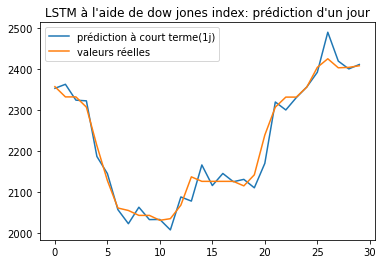

In [102]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df_bdi[-30:].values,label='valeurs réelles')
plt.title("LSTM à l'aide de dow jones index: prédiction d'un jour")
plt.legend()

#### mois

In [103]:
train_df=df_diff[:-300].values

time_step = 3
X_train, y_train = create_dataset_30j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_30j=creat_model_30j()
model_30j.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 3, 50)             10600     
                                                                 
 lstm_27 (LSTM)              (None, 50)                20200     
                                                                 
 dense_13 (Dense)            (None, 30)                1530      
                                                                 
Total params: 32,330
Trainable params: 32,330
Non-trainable params: 0
_________________________________________________________________


In [104]:
hist_30j=model_30j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

p=-300
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_30j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,2)) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], prediction.reshape(30,)
    
    if p==-30:
        test_df=df_bdi[-30:]
    else:
        test_df=df_bdi[p:p+30]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test_df.index)
    values.append(serie[-30:].values.reshape((30,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=30
rmses=rmses/10
maes=maes/10


Epoch 1/100
51/51 [==============================] - 9s 13ms/step - loss: 774.2896
Epoch 2/100
51/51 [==============================] - 1s 14ms/step - loss: 771.7655
Epoch 3/100
51/51 [==============================] - 1s 14ms/step - loss: 766.5332
Epoch 4/100
51/51 [==============================] - 1s 15ms/step - loss: 762.5461
Epoch 5/100
51/51 [==============================] - 1s 14ms/step - loss: 759.9532
Epoch 6/100
51/51 [==============================] - 1s 15ms/step - loss: 757.8273
Epoch 7/100
51/51 [==============================] - 1s 14ms/step - loss: 756.3344
Epoch 8/100
51/51 [==============================] - 1s 14ms/step - loss: 755.0359
Epoch 9/100
51/51 [==============================] - 1s 14ms/step - loss: 753.7291
Epoch 10/100
51/51 [==============================] - 1s 14ms/step - loss: 752.9388
Epoch 11/100
51/51 [==============================] - 1s 14ms/step - loss: 751.9489
Epoch 12/100
51/51 [==============================] - 1s 13ms/step - loss: 750.8276
E

In [105]:
maes,rmses

(409.1817704264323, 496.62119469760285)

In [106]:
values

[array([3211.86938477, 3175.25366211, 3142.03857422, 3109.70263672,
        3077.90917969, 3050.87304688, 3029.47802734, 3011.54199219,
        2996.27539062, 2980.08862305, 2964.48754883, 2951.16479492,
        2941.38330078, 2934.52270508, 2928.68457031, 2921.43237305,
        2913.36499023, 2904.99707031, 2897.72338867, 2893.14746094,
        2891.58178711, 2889.69555664, 2888.88623047, 2890.48461914,
        2894.16625977, 2899.93505859, 2906.17675781, 2912.69213867,
        2919.72680664, 2926.80615234]),
 array([3287.75244141, 3294.35864258, 3301.73999023, 3308.96801758,
        3316.29663086, 3325.21582031, 3334.11181641, 3342.92651367,
        3350.00463867, 3354.55834961, 3359.09423828, 3366.9777832 ,
        3376.47583008, 3383.70556641, 3389.60375977, 3394.89379883,
        3401.36645508, 3409.87768555, 3421.04516602, 3432.30957031,
        3441.33618164, 3448.1081543 , 3452.69433594, 3455.52905273,
        3456.52612305, 3456.50097656, 3456.62817383, 3457.70239258,
        

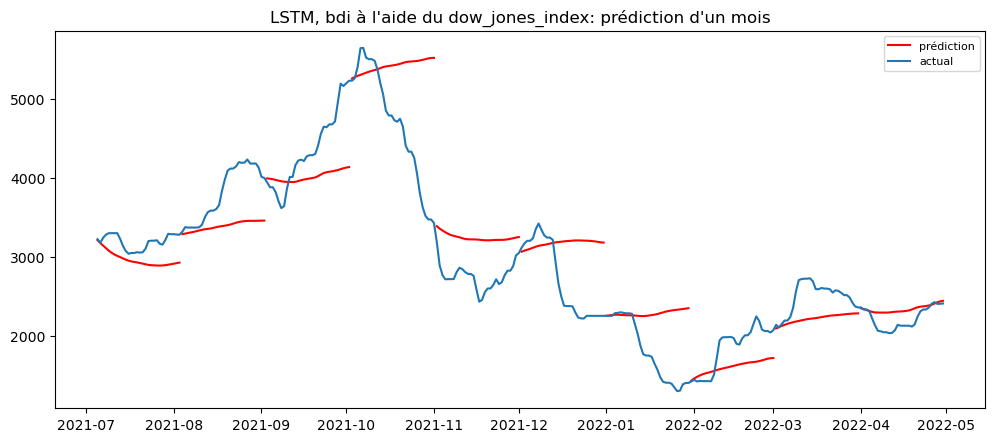

In [107]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-300:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide du dow_jones_index: prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

#### semaine

In [108]:
train_df=df_diff[:-70].values

time_step = 3
X_train, y_train = create_dataset_7j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 2)

model_7j=creat_model_7j()
model_7j.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 3, 50)             10600     
                                                                 
 lstm_29 (LSTM)              (None, 50)                20200     
                                                                 
 dense_14 (Dense)            (None, 7)                 357       
                                                                 
Total params: 31,157
Trainable params: 31,157
Non-trainable params: 0
_________________________________________________________________


In [109]:
hist_7j=model_7j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-70
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_7j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,2)) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], prediction.reshape(7,)
    
    if p==-7:
        test_df=df_bdi[-7:]
    else:
        test_df=df_bdi[p:p+7]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test_df.index)
    values.append(serie[-7:].values.reshape((7,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=7
rmses=rmses/10
maes=maes/10


1/1 [==============================] - 0s 47ms/step


In [110]:
maes,rmses

(97.51558489118304, 122.614613896723)

In [111]:
values

[array([2014.23852539, 2022.25598145, 2030.10131836, 2038.06811523,
        2043.6529541 , 2048.17163086, 2052.34130859]),
 array([2043.86437988, 2039.14343262, 2034.34143066, 2025.48583984,
        2014.2244873 , 2003.64990234, 1996.54785156]),
 array([2223.13037109, 2245.77880859, 2265.52319336, 2286.18725586,
        2305.31665039, 2321.44140625, 2333.48388672]),
 array([2732.42456055, 2736.9230957 , 2739.54418945, 2740.47583008,
        2738.19311523, 2733.29394531, 2729.45581055]),
 array([2584.56445312, 2574.0715332 , 2564.89697266, 2554.40185547,
        2542.33911133, 2531.26708984, 2523.83251953]),
 array([2498.18017578, 2492.9597168 , 2487.95385742, 2478.59838867,
        2466.56982422, 2454.81005859, 2446.63256836]),
 array([2322.53076172, 2319.49633789, 2320.73486328, 2324.66455078,
        2333.45898438, 2343.82666016, 2353.58178711]),
 array([2027.80041504, 2021.29968262, 2013.17285156, 1998.49853516,
        1978.45422363, 1958.26037598, 1943.35510254]),
 array([2114.336

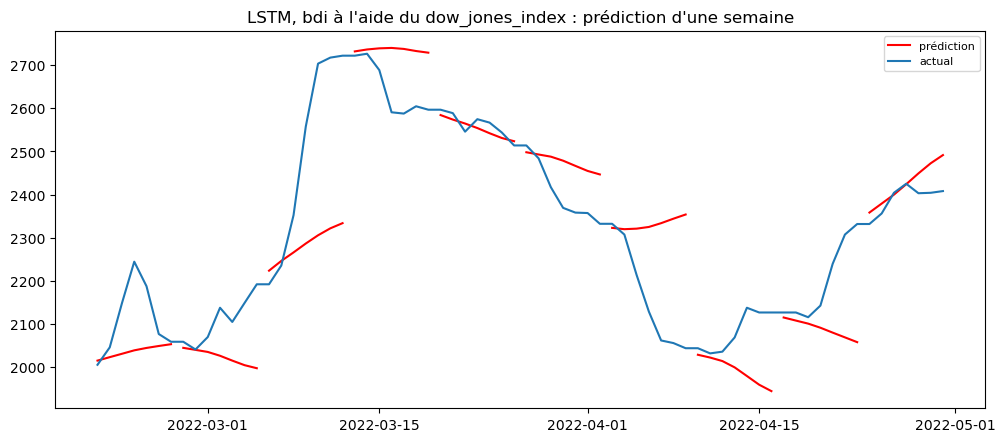

In [112]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-70:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide du dow_jones_index : prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

### à l'aide du bsi,bci,bpi,steel,et dow jones index

In [113]:
df_bdi_multivars1=pd.concat([df_bdi,df_bsi,df_bci,df_bpi,china_steel,dow_jones_index],axis=1).dropna()

In [114]:
df_diff=df_bdi_multivars1.diff().dropna()

In [115]:
model = VAR(df_diff, freq="1D")
model.select_order(20).summary()
# 5 7 20

,AIC,BIC,FPE,HQIC
0,42.78,42.81,3.810e+18,42.79
1,40.56,40.75,4.130e+17,40.63
2,40.26,40.61*,3.062e+17,40.39
3,40.11,40.62,2.626e+17,40.30*
4,40.10,40.77,2.609e+17,40.36
5,40.10,40.93,2.595e+17,40.41
6,40.10,41.09,2.592e+17,40.47
7,40.09*,41.25,2.587e+17*,40.53
8,40.12,41.44,2.660e+17,40.62
9,40.15,41.63,2.742e+17,40.71


#### jour

In [116]:
train_df=df_diff[:-30].values

time_step = 3
X_train, y_train = create_dataset_1j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 6)

model_1j=creat_model_1j()
model_1j.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 3, 50)             11400     
                                                                 
 lstm_31 (LSTM)              (None, 50)                20200     
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 31,651
Trainable params: 31,651
Non-trainable params: 0
_________________________________________________________________


In [117]:
hist_1j=model_1j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
n_past=3
for i in range(30):
    if p==-1:
        test_df=df_bdi[-1:]
    else:
        test_df=df_bdi[p:p+1]
    test_predict=model_1j.predict(df_diff[p-n_past:p].values.reshape(1,n_past,6))
    x, x_diff = df_bdi['BDI'].iloc[p-1], test_predict.reshape(1,)
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test_df.index)
    values.append(serie[-1:].values.reshape((1,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=1
rmses=rmses/30
maes=maes/30


1/1 [==============================] - 0s 40ms/step


In [118]:
maes,rmses

(23.49630126953125, 23.49630126953125)

In [119]:
values

[array([2317.63012695]),
 array([2331.79931641]),
 array([2270.12158203]),
 array([2284.64160156]),
 array([2227.38867188]),
 array([2135.46606445]),
 array([2050.08374023]),
 array([2039.9810791]),
 array([2080.23852539]),
 array([2017.72473145]),
 array([2042.90039062]),
 array([2005.9510498]),
 array([2061.71728516]),
 array([2062.03930664]),
 array([2191.85009766]),
 array([2127.54492188]),
 array([2108.36523438]),
 array([2109.24853516]),
 array([2132.10864258]),
 array([2132.12963867]),
 array([2187.79394531]),
 array([2286.77709961]),
 array([2315.88085938]),
 array([2312.84594727]),
 array([2343.39404297]),
 array([2364.11401367]),
 array([2438.89086914]),
 array([2423.98901367]),
 array([2412.29003906]),
 array([2426.4609375])]

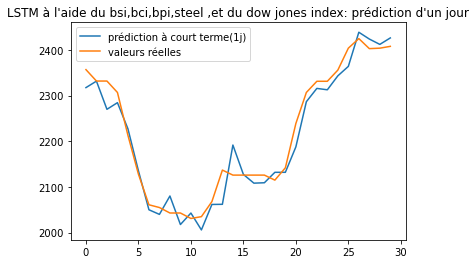

In [120]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df_bdi[-30:].values,label='valeurs réelles')
plt.title("LSTM à l'aide du bsi,bci,bpi,steel ,et du dow jones index: prédiction d'un jour")
plt.legend()

#### mois

In [121]:
train_df=df_diff[:-300].values

time_step = 3
X_train, y_train = create_dataset_30j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 6)

model_30j=creat_model_30j()
model_30j.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 3, 50)             11400     
                                                                 
 lstm_33 (LSTM)              (None, 50)                20200     
                                                                 
 dense_16 (Dense)            (None, 30)                1530      
                                                                 
Total params: 33,130
Trainable params: 33,130
Non-trainable params: 0
_________________________________________________________________


In [122]:
hist_30j=model_30j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

p=-300
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_30j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,6)) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], prediction.reshape(30,)
    
    if p==-30:
        test_df=df_bdi[-30:]
    else:
        test_df=df_bdi[p:p+30]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test_df.index)
    values.append(serie[-30:].values.reshape((30,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=30
rmses=rmses/10
maes=maes/10


Epoch 1/100
13/13 [==============================] - 8s 13ms/step - loss: 1662.9122
Epoch 2/100
13/13 [==============================] - 0s 14ms/step - loss: 1661.9324
Epoch 3/100
13/13 [==============================] - 0s 13ms/step - loss: 1660.8855
Epoch 4/100
13/13 [==============================] - 0s 13ms/step - loss: 1659.2061
Epoch 5/100
13/13 [==============================] - 0s 14ms/step - loss: 1656.4622
Epoch 6/100
13/13 [==============================] - 0s 14ms/step - loss: 1651.9412
Epoch 7/100
13/13 [==============================] - 0s 13ms/step - loss: 1645.8306
Epoch 8/100
13/13 [==============================] - 0s 13ms/step - loss: 1638.2422
Epoch 9/100
13/13 [==============================] - 0s 13ms/step - loss: 1630.4597
Epoch 10/100
13/13 [==============================] - 0s 13ms/step - loss: 1622.3821
Epoch 11/100
13/13 [==============================] - 0s 13ms/step - loss: 1614.6110
Epoch 12/100
13/13 [==============================] - 0s 15ms/step - loss:

In [123]:
maes,rmses

(438.57052490234383, 524.375331103523)

In [124]:
_list_maes

[246.4263427734375,
 448.82721354166665,
 451.58428548177085,
 781.54140625,
 461.32696940104165,
 385.0480061848958,
 723.6415771484375,
 618.6382405598958,
 133.98748372395832,
 134.68372395833333]

In [125]:
_list_rmses

[288.26695322006816,
 545.0015559824625,
 583.8971020619846,
 1018.4064091194084,
 475.0291807683128,
 416.623704979486,
 887.9008785987472,
 692.8719117837297,
 187.45466847354658,
 148.30094604748297]

In [126]:
values

[array([3243.70996094, 3232.42407227, 3223.49291992, 3215.87548828,
        3209.74633789, 3207.94067383, 3210.24462891, 3215.06591797,
        3222.54956055, 3232.32373047, 3246.16088867, 3266.05053711,
        3290.63623047, 3315.17089844, 3339.140625  , 3363.99243164,
        3391.75390625, 3422.09008789, 3453.59594727, 3485.84814453,
        3517.17749023, 3546.65576172, 3576.12451172, 3606.10302734,
        3636.38598633, 3667.63818359, 3696.81152344, 3721.68359375,
        3742.26513672, 3759.96313477]),
 array([3287.69067383, 3293.99536133, 3300.62841797, 3307.7019043 ,
        3314.43066406, 3320.93603516, 3327.24536133, 3333.13720703,
        3338.27099609, 3341.68115234, 3346.37646484, 3351.06982422,
        3356.43896484, 3360.91699219, 3364.51269531, 3367.06201172,
        3369.7668457 , 3373.359375  , 3376.41333008, 3379.66333008,
        3383.41333008, 3387.39501953, 3389.7019043 , 3393.35107422,
        3397.67431641, 3401.96655273, 3406.60522461, 3409.65234375,
        

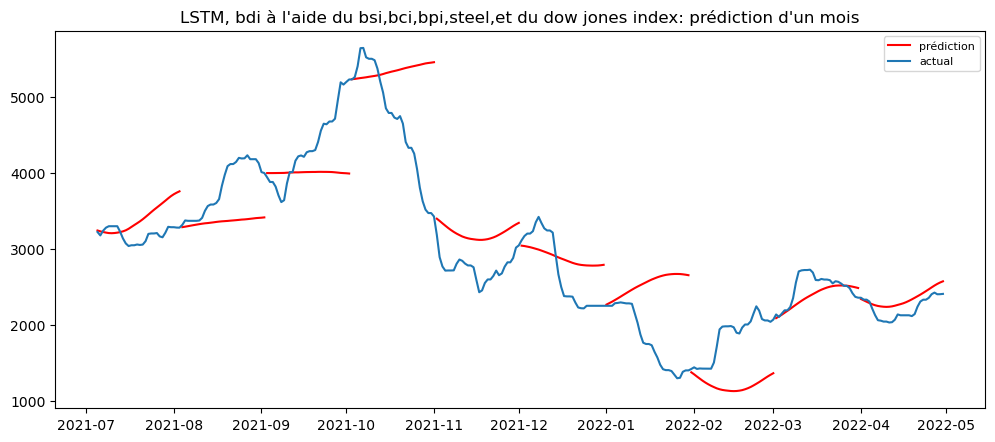

In [127]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-300:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide du bsi,bci,bpi,steel,et du dow jones index: prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

#### semaine

In [128]:
train_df=df_diff[:-70].values

time_step = 3
X_train, y_train = create_dataset_7j(train_df, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 6)

model_7j=creat_model_7j()
model_7j.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 3, 50)             11400     
                                                                 
 lstm_35 (LSTM)              (None, 50)                20200     
                                                                 
 dense_17 (Dense)            (None, 7)                 357       
                                                                 
Total params: 31,957
Trainable params: 31,957
Non-trainable params: 0
_________________________________________________________________


In [129]:
hist_7j=model_7j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)

p=-70
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_7j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,6)) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], prediction.reshape(7,)
    
    if p==-7:
        test_df=df_bdi[-7:]
    else:
        test_df=df_bdi[p:p+7]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test_df.index)
    values.append(serie[-7:].values.reshape((7,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=7
rmses=rmses/10
maes=maes/10


1/1 [==============================] - 0s 38ms/step


In [130]:
maes,rmses

(109.29674595424106, 129.997037445471)

In [131]:
_list_maes

[143.27755301339286,
 147.45614188058036,
 196.92054966517858,
 171.34650530133928,
 45.451416015625,
 177.82672991071428,
 80.30168805803571,
 37.5386962890625,
 53.709437779017854,
 39.138741629464285]

In [132]:
_list_rmses

[168.08821035882193,
 174.02898714175964,
 243.41605805887113,
 203.87048793167028,
 54.0996106468215,
 203.732901470482,
 91.56633787634937,
 49.83270377833264,
 66.87946972221332,
 44.45560746938821]

In [133]:
values

[array([1991.35620117, 1979.46740723, 1968.01818848, 1959.64538574,
        1954.68005371, 1952.66845703, 1953.72143555]),
 array([2030.03881836, 2003.55786133, 1977.82019043, 1955.35461426,
        1934.69506836, 1914.84191895, 1898.99853516]),
 array([2217.88208008, 2247.60327148, 2279.31567383, 2312.64331055,
        2346.22021484, 2375.9831543 , 2400.87915039]),
 array([2740.15527344, 2761.22705078, 2784.86767578, 2811.77172852,
        2842.61352539, 2875.18725586, 2903.10302734]),
 array([2600.33642578, 2604.17773438, 2607.83203125, 2609.38232422,
        2609.41992188, 2609.03417969, 2609.97729492]),
 array([2527.98876953, 2545.56176758, 2563.83276367, 2583.984375  ,
        2603.87548828, 2619.53149414, 2631.01245117]),
 array([2302.97509766, 2273.67651367, 2245.07470703, 2218.87353516,
        2195.52075195, 2177.13330078, 2163.16113281]),
 array([2034.50476074, 2030.73498535, 2029.82019043, 2034.43493652,
        2044.71325684, 2058.23974609, 2070.78125   ]),
 array([2159.124

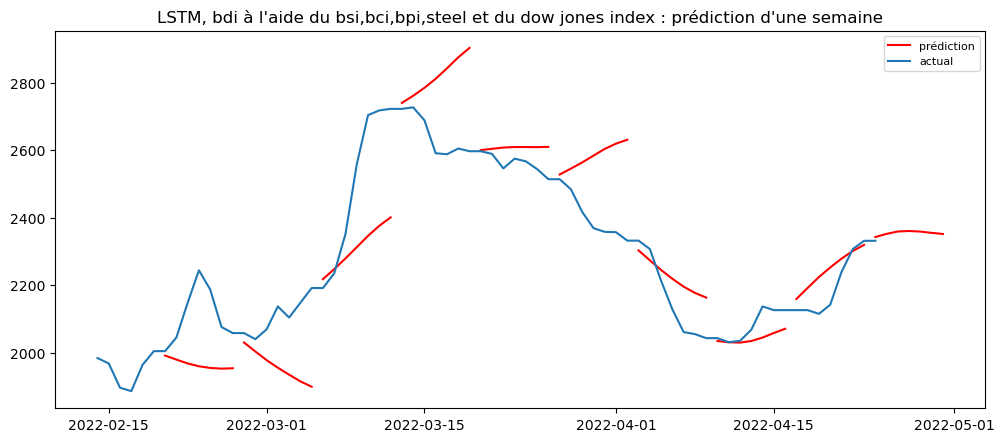

In [134]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-70:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide du bsi,bci,bpi,steel et du dow jones index : prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

In [135]:
st

NameError: name 'st' is not defined

### à l'aide du bsi,bci,bpi, et du china steel

In [ ]:
df_bdi_multivars=pd.concat([df_bdi,df_bsi,df_bci,df_bpi,china_steel],axis=1).dropna()

In [ ]:
df_diff=df_bdi_multivars.diff().dropna()

In [ ]:
model = VAR(df_diff, freq="1D")
model.select_order(20).summary()

#### mois

In [ ]:
p=-300
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
_10_loss=np.array([0 for i in range(100)])
n_past=3
values=[]
for i in range(10):
    train_df=df_diff[:p].values
    X_train, y_train = create_dataset(train_df, n_past)
    if p==-30:
        test_df=df_bdi[-30:]
    else:
        test_df=df_bdi[p:p+30]
    model=creat_model()
    hist=model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)
    #real_test_predict=scaler.inverse_transform(model.predict(train_df[-3:].reshape((1,3,1)))).reshape(30,)
    test_predict=model.predict(train_df[-n_past:].reshape(1,n_past,5))
    x, x_diff = df_bdi['BDI'].iloc[p-1], test_predict.reshape(30,)
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test_df.index)
    values.append(serie[-30:].values.reshape((30,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    _10_loss=_10_loss+np.array(hist.history['loss'])
    p+=30
rmses=rmses/10
maes=maes/10
_10_loss=_10_loss/10

In [ ]:
maes,rmses

In [ ]:
_10_loss

In [ ]:
_list_maes

In [ ]:
_list_rmses

In [ ]:
for p in prédictions:
    print (p.values)
    print ('\n****\n')

In [ ]:
values

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-300:].BDI, label='actual')

plt.title("LSTM, bdi à l'aide du bsi,bci,bpi, et china steel: prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

#### semaine

In [ ]:
p=-76
n_past=3
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
_10_loss=np.array([0 for i in range(100)])
for i in range(10):
    train_df=df_diff[:p].values
    X_train, y_train = create_dataset2(train_df, n_past)
    
    
    test_df=df_bdi[p:p+7]
    
    
    model=creat_model2()
    hist=model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)
    #real_test_predict=scaler.inverse_transform(model.predict(train_df[-3:].reshape((1,3,1)))).reshape(30,)
    test_predict=model.predict(train_df[-n_past:].reshape(1,n_past,5))
    x, x_diff = df_bdi['BDI'].iloc[p-1], test_predict.reshape(7,)
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test_df.index)
    
    values.append(serie[-7:].values.reshape((7,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    _10_loss=_10_loss+np.array(hist.history['loss'])
    p+=7
rmses=rmses/10
maes=maes/10
_10_loss=_10_loss/10

In [ ]:
maes,rmses

In [ ]:
_10_loss

In [ ]:
_list_maes

In [ ]:
_list_rmses

In [ ]:
values

In [ ]:
for p in prédictions:
    print (p.values)
    print ('\n****\n')

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df_bdi[-76:-6].BDI, label='actual')

plt.title("LSTM, bdi à l'aide du bsi,bci,bpi, et china steel : prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

In [ ]:
STOP

In [ ]:
x, x_diff = df['BDI'].iloc[0], scaler.inverse_transform(df1).reshape((scaler.inverse_transform(df1).shape[0]),)
f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float),index=df.index)

In [ ]:
df_diff=df_bdi.diff().dropna()

In [ ]:
plot_pacf(df_diff)
plt.show()

In [ ]:
#train=df1[:-30]
train=df_diff[:-30].values

In [ ]:
train

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-30):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step:i + time_step+30, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 3
X_train, y_train = create_dataset(train, time_step)
#X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
#X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
def creat_model():
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(3,1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(30))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return(model)

In [ ]:
model=creat_model()
model.summary()

In [ ]:
initial_weights=model.get_weights()

In [ ]:
model.set_weights(initial_weights)

In [ ]:
hist=model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(train[-3:].reshape(1,3,1))

In [ ]:
x, x_diff = df_bdi['BDI'].iloc[-31], test_predict.reshape(30,)
f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float))

real_train_predict=scaler.inverse_transform(train_predict)
real_test_predict=scaler.inverse_transform(test_predict).reshape(30)

real_train_predict.shape

In [ ]:
df[-30:].values -f_bdi[-30:].values

In [ ]:
import math
#mae = np.mean(np.abs(df[-30:].BDI.values -real_test_predict))#df[-30:].values -f_bdi[-30:].values
mae = np.mean(np.abs(df_bdi[-30:].values -f_bdi[-30:].values))#
mae
#10 132.94 152.61
#35 266.80 303.50
#4 164.24 183.21
# diff 160.27 199.38
#diff9 3 106.92 127.87
#diff9 9 246.78 284.42
#diff3 139.28 172.76
###
# diff 3 127.60 151.08
# diff 9 263.44 319.21

In [ ]:
rmse = np.mean((df[-30:].values -f_bdi[-30:].values)**2)**.5
rmse

In [ ]:
p=-300
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
_10_loss=np.array([0 for i in range(100)])
for i in range(10):
    train_df=df_diff[:p].values
    X_train, y_train = create_dataset(train_df, 3)
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    if p==-30:
        test_df=df[-30:]
    else:
        test_df=df[p:p+30]
    model=creat_model()
    hist=model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)
    #real_test_predict=scaler.inverse_transform(model.predict(train_df[-3:].reshape((1,3,1)))).reshape(30,)
    test_predict=model.predict(train_df[-3:].reshape(1,3,1))
    x, x_diff = df['BDI'].iloc[p-1], test_predict.reshape(30,)
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test_df.index)
    
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    _10_loss=_10_loss+np.array(hist.history['loss'])
    p+=30
rmses=rmses/10
maes=maes/10
_10_loss=_10_loss/10

In [ ]:
real_test_predict.shape

In [ ]:
rmses,maes
#10 (597.1814230503035, 512.1784798177083)
#   3 (547.2645591069712, 467.52592610677095)

In [ ]:
_list_rmses

In [ ]:
_10_loss

In [ ]:
for p in prédictions:
    print (p.values)
    print ('\n****\n')

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    plt.plot(prédictions[i],color='r')
plt.plot(df[-300:].BDI, label='actual')

plt.title("LSTM : prédiction d'un mois")
plt.legend(loc='upper left', fontsize=8)
plt.show()

### prediction d'une semaine

In [ ]:
train=df_diff[:-13].values


In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset2(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-7):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step:i + time_step+7, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 3
X_train, y_train = create_dataset2(train, time_step)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)

In [ ]:
def creat_model2():
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(3,1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(7))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return(model)

In [ ]:
model=creat_model2()
model.summary()

In [ ]:
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(train[-3:].reshape((1,3,1)))

In [ ]:
x, x_diff = df['BDI'].iloc[-14], test_predict.reshape(7,)
f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float))

In [ ]:
#mae = np.mean(np.abs(df[-13:-6].BDI.values - real_test_predict))
mae = np.mean(np.abs(df[-13:-6].values - f_bdi[-7:].values))
mae
#54.87

In [ ]:
rmse = np.mean((df[-13:-6].values - f_bdi[-7:].values)**2)**.5
rmse

In [ ]:
"""d=-76
rmses=0
rmsesl=[]
maes=0
predictions=[]
for j in range(10):
    train=df1[:d]
    X_train, y_train = create_dataset2(train, time_step)
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    test=df[d:d+7]
    model=creat_model2()
    model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)
    real_test_predict=scaler.inverse_transform(model.predict(train[-10:].reshape((1,10,1))))
    mae = np.mean(np.abs(test.BDI.values - real_test_predict))
    maes=maes+mae
    rmse = np.mean((test.BDI.values - real_test_predict)**2)**.5
    rmses=rmses+rmse
    rmsesl.append(rmse)
    predictions.append(real_test_predict)
    d+=7
rmses=rmses/10
maes=maes/10"""
p=-76
time_step=3
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
_10_loss=np.array([0 for i in range(100)])
for i in range(10):
    train_df=df_diff[:p].values
    X_train, y_train = create_dataset2(train_df, time_step)
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    
    test_df=df[p:p+7]
    
    
    model=creat_model2()
    hist=model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=0)
    #real_test_predict=scaler.inverse_transform(model.predict(train_df[-3:].reshape((1,3,1)))).reshape(30,)
    test_predict=model.predict(train_df[-3:].reshape(1,3,1))
    x, x_diff = df['BDI'].iloc[p-1], test_predict.reshape(7,)
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test_df.index)
    
    
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    _10_loss=_10_loss+np.array(hist.history['loss'])
    p+=7
rmses=rmses/10
maes=maes/10
_10_loss=_10_loss/10

In [ ]:
rmses,maes

In [ ]:
_10_loss

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    plt.plot(prédictions[i],color='r')
plt.plot(df[-76:-6].BDI, label='actual')

plt.title("LSTM : prédiction d'une semaine")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
prédictions

In [ ]:
for p in prédictions:
    print (p.values)
    print ('\n****\n')